In [1]:
from camera import Camera, FakeCamera
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
cameras = [FakeCamera("test.jpg", width=1000, height=1000), FakeCamera("test2.jpeg", width=1000, height=1000)]

imgs = {}
imgs["original"] = [cam.get_frame()[1] for cam in cameras]
imgs["gray"] = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs["original"]]
imgs["gray_blur"] = [cv2.GaussianBlur(img, (5, 5), 0) for img in imgs["gray"]]

other_data = {}

In [3]:
def draw_points(img, points, color=(0, 0, 255)):
    width, height = img.shape[:2]
    for point in points:
        x, y = point
        x, y = int(x), int(y)
        if x < 0 or x >= width or y < 0 or y >= height:
            continue
        cv2.circle(img, (x, y), 5, color, -1)

def draw_algebraic_lines(img, lines, color=(0, 0, 255)):
    for line in lines:
        rho, theta = line
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 100000 * (-b))
        y1 = int(y0 + 100000 * (a))
        x2 = int(x0 - 100000 * (-b))
        y2 = int(y0 - 100000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), color, 2)

def show_imgs(key):
    fig, axs = plt.subplots(1, len(cameras), figsize=(12, 12))
    for i, img in enumerate(imgs[key]):
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(key)
        axs[i].axis("off")
    plt.show()

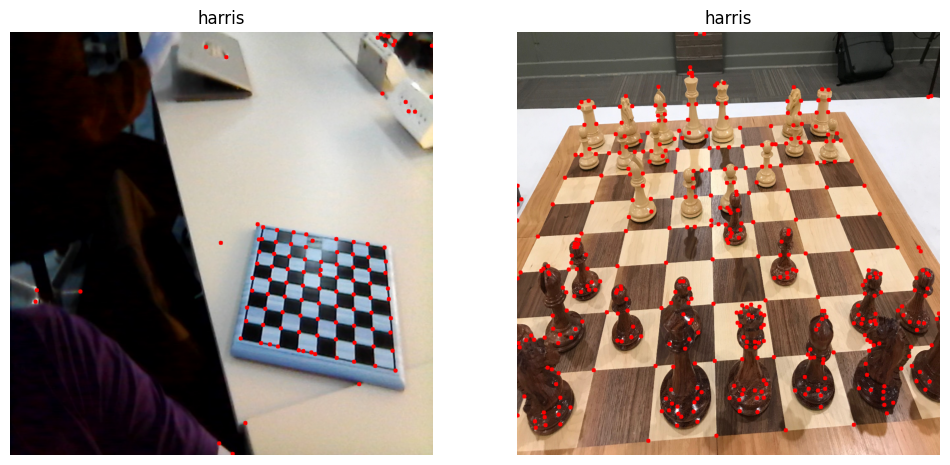

In [4]:
def harris_corners(gray_img):
    # find Harris corners
    blur = cv2.GaussianBlur(gray_img, (5, 5), 0)
    dst = cv2.cornerHarris(blur, 2, 3, 0.02)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst, None)

    # find centroids
    ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    # draw centroids
    #for i in range(1, len(centroids)):
    #    cv2.circle(img, (int(centroids[i][0]), int(centroids[i][1])), 1, (0, 0, 255), -1)

    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray_img, np.float32(centroids), (5, 5), (-1, -1), criteria)

    return corners

other_data["corners"] = [harris_corners(img) for img in imgs["gray_blur"]]

imgs["harris"] = [img.copy() for img in imgs["original"]]

for img, corner in zip(imgs["harris"], other_data["corners"]):
    draw_points(img, corner)

show_imgs("harris")

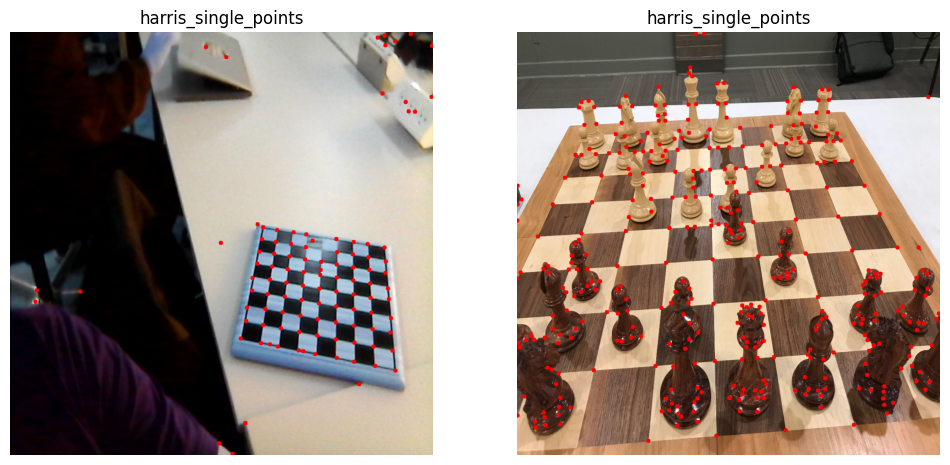

In [5]:
def remove_nearby_points(points, threshold):
    new_points = []
    for point in points:
        if len(new_points) == 0:
            new_points.append(point)
            continue
        for new_point in new_points:
            if np.linalg.norm(point - new_point) < threshold:
                break
        else:
            new_points.append(point)
    return new_points

other_data["corners_single_points"] = [remove_nearby_points(corner, 10) for corner in other_data["corners"]]
imgs["harris_single_points"] = [img.copy() for img in imgs["original"]]
for img, corner in zip(imgs["harris_single_points"], other_data["corners_single_points"]):
    draw_points(img, corner)

show_imgs("harris_single_points")

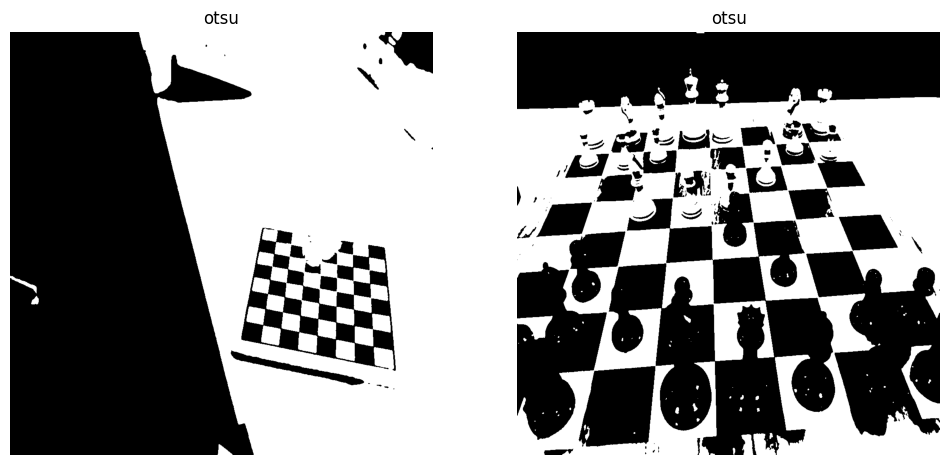

In [6]:
def otsu_binary(gray_img):
    ret2,th2 = cv2.threshold(gray_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th2

imgs["otsu"] = [otsu_binary(img) for img in imgs["gray_blur"]]
show_imgs("otsu")

50 227
55 249


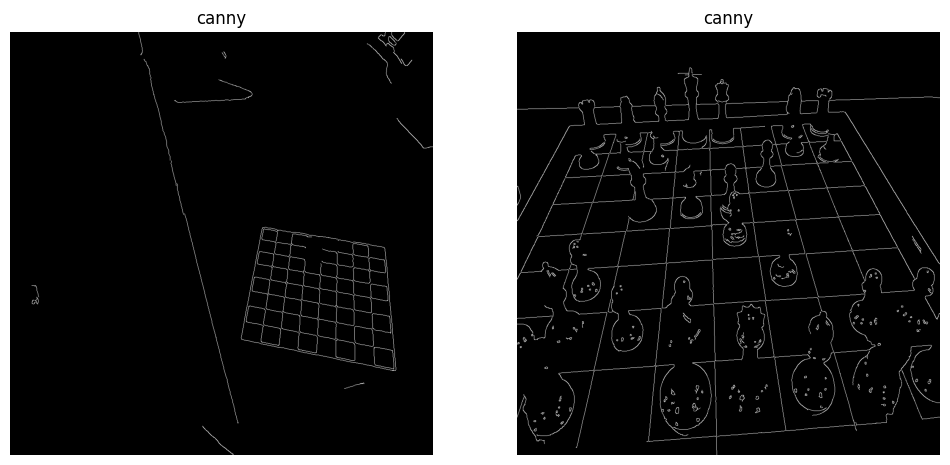

In [7]:
def canny_edges(gray_img, sigma = 0.5):
    v = np.median(gray_img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma*2.5) * v))
    print(lower, upper)
    return cv2.Canny(gray_img, 80, 255)

imgs["canny"] = [canny_edges(img) for img in imgs["gray_blur"]]

show_imgs("canny")

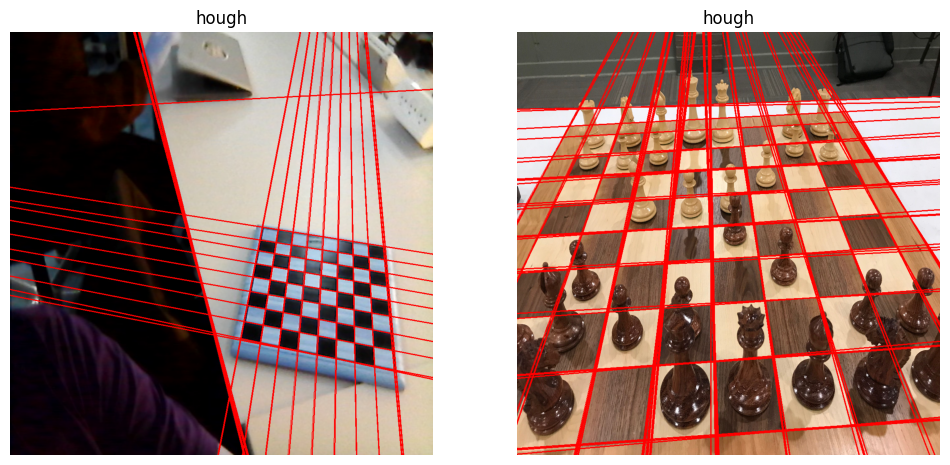

In [8]:
def hough_lines(canny_img):
    lines = cv2.HoughLines(canny_img, 1, math.pi/180.0, 100, np.array([]), 0, 0)
    if lines is None:
        return []
    return [line[0] for line in lines]

imgs["hough"] = [img.copy() for img in imgs["original"]]
other_data["hough"] = [hough_lines(img) for img in imgs["canny"]]

for img, lines in zip(imgs["hough"], other_data["hough"]):
    draw_algebraic_lines(img, lines)

show_imgs("hough")

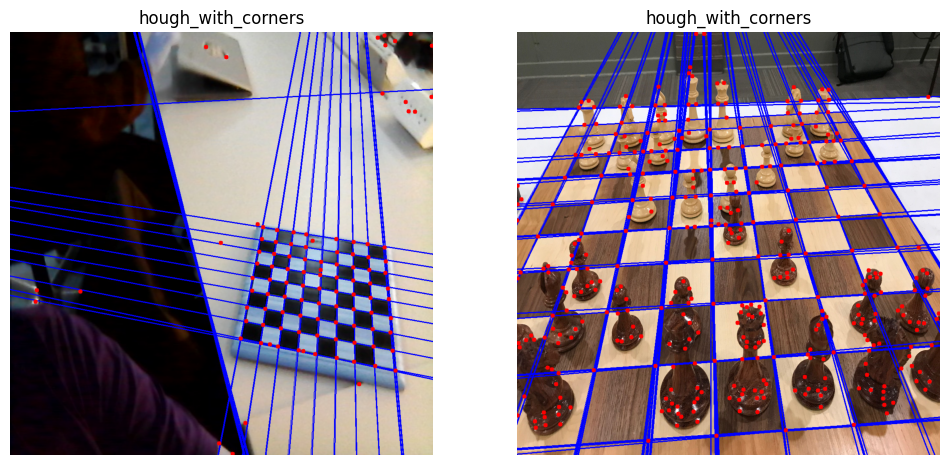

In [9]:
imgs["hough_with_corners"] = [img.copy() for img in imgs["original"]]
for img, lines, corners in zip(imgs["hough_with_corners"], other_data["hough"], other_data["corners_single_points"]):
    draw_algebraic_lines(img, lines, color=(255, 0, 0))
    draw_points(img, corners)

show_imgs("hough_with_corners")

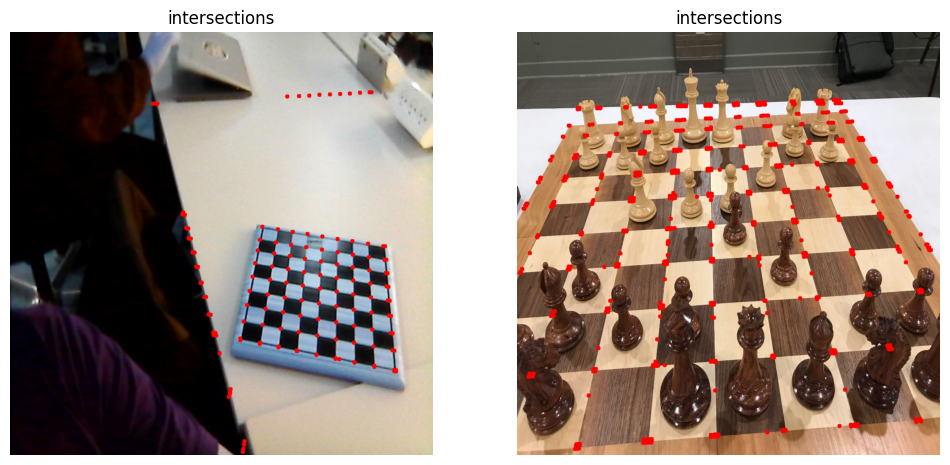

In [10]:
# find intersections between lines

def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [math.cos(theta1), math.sin(theta1)],
        [math.cos(theta2), math.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    try:
        x0, y0 = np.linalg.solve(A, b)
        x0, y0 = int(x0), int(y0)
        return (x0, y0)
    except np.linalg.LinAlgError:
        return None

def find_intersections(lines):
    intersections = []
    for i, line1 in enumerate(lines):
        for line2 in lines[i+1:]:
            intersection_point = intersection(line1, line2)
            if intersection_point is not None:
                intersections.append(intersection_point)
    return intersections

other_data["intersections"] = [find_intersections(lines) for lines in other_data["hough"]]

imgs["intersections"] = [img.copy() for img in imgs["original"]]
for img, intersections in zip(imgs["intersections"], other_data["intersections"]):
    draw_points(img, intersections)

show_imgs("intersections")

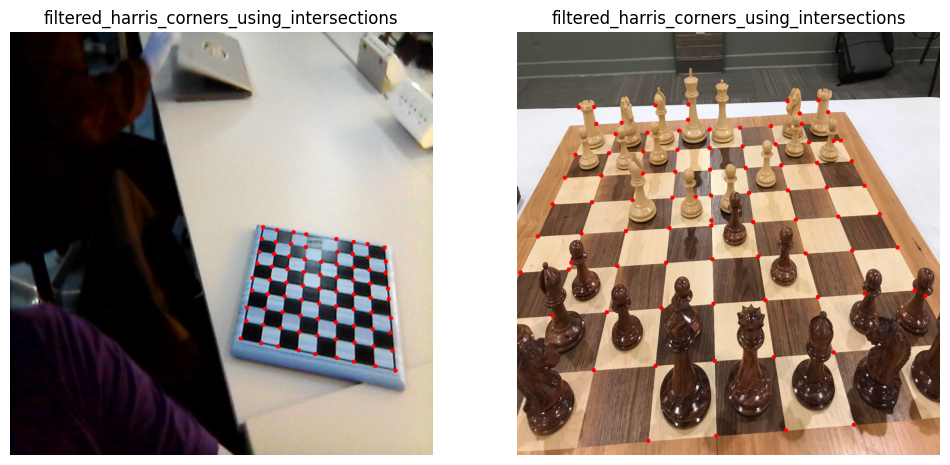

In [11]:
def filter_harris_corners_using_intersections(harris, intersections, margin = 10):
    filtered_corners = []
    for corner in harris:
        for intersection in intersections:
            if abs(corner[0] - intersection[0]) < margin and abs(corner[1] - intersection[1]) < margin:
                filtered_corners.append(corner)
                break
    return filtered_corners

other_data["filtered_harris_corners_using_intersections"] = [filter_harris_corners_using_intersections(harris, intersections) for harris, intersections in zip(other_data["corners_single_points"], other_data["intersections"])]

imgs["filtered_harris_corners_using_intersections"] = [img.copy() for img in imgs["original"]]
for img, corners in zip(imgs["filtered_harris_corners_using_intersections"], other_data["filtered_harris_corners_using_intersections"]):
    draw_points(img, corners)

show_imgs("filtered_harris_corners_using_intersections")

In [12]:
def get_harris_points_for_line(line, harris_corners, margin = 5):
    rho, theta = line
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a*rho
    y0 = b*rho
    p1 = np.array([x0 + 1000*(-b), y0 + 1000*(a)])
    p2 = np.array([x0 - 1000*(-b), y0 - 1000*(a)])

    points = []
    combined_dist = 0
    for i, corner in enumerate(harris_corners):
        p3 = np.array(corner)
        d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
        if d < margin:
            combined_dist += d
            points.append(i)
    
    return combined_dist, points

other_data["corner_points_for_line"] = [[get_harris_points_for_line(line, corners) for line in lines] for lines, corners in zip(other_data["hough"], other_data["filtered_harris_corners_using_intersections"])]

for corners in other_data["corner_points_for_line"]:
    print(corners)

[(0, []), (3.626473027533967, [57, 59, 61, 63, 65, 66, 69, 71, 73]), (4.846387661203277, [21, 23, 25, 27, 29, 31, 33, 35, 37]), (21.307364557841378, [11, 19, 28, 37, 46, 55, 64, 73, 78]), (4.045664693076323, [9, 17, 26, 35, 44, 53, 62, 71, 77]), (8.808523019575981, [30, 32, 34, 36, 38, 40, 42, 44, 46]), (0, []), (7.091826234742241, [0, 30, 49, 67]), (7.05264396396595, [1, 6, 14, 23, 32, 41, 50, 59, 68]), (6.765400580877475, [2, 8, 16, 25, 34, 43, 52, 61, 70]), (4.434537250138819, [50, 52, 54, 56, 58, 60, 62, 64]), (4.34887051071394, [20, 29, 38, 47, 56, 65, 74]), (6.234409160670242, [7, 15, 24, 33, 42, 51, 60, 69, 76]), (8.667673896567432, [3, 10, 18, 27, 36, 45, 54, 63, 72]), (5.5079778041024685, [12, 14, 16, 18, 20, 22, 24, 26, 28]), (11.216838401131858, [39, 41, 43, 45, 47, 48, 51, 53, 55]), (9.24270739575163, [5, 13, 22, 31, 40, 48, 58, 66, 75]), (16.406236459758947, [67, 68, 70, 72, 74, 75, 76, 77, 78]), (17.599301421790503, [11, 19, 28, 37, 46, 55, 64, 73, 78]), (0, []), (9.78051

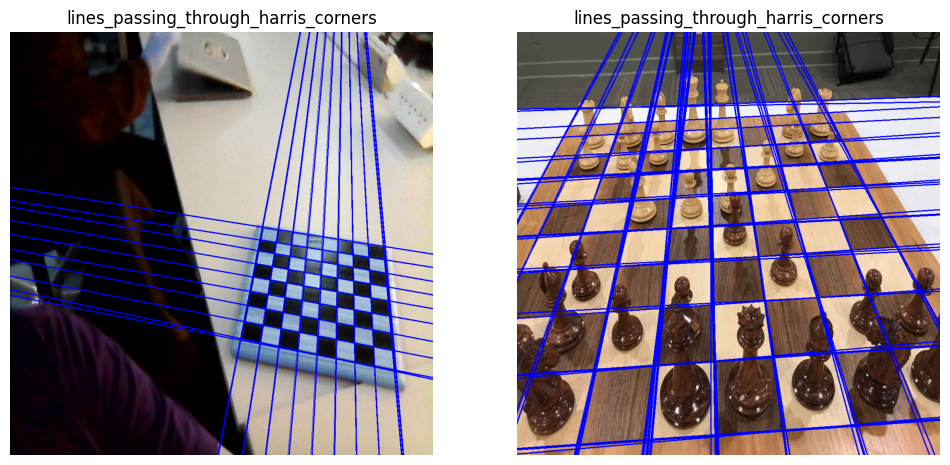

In [13]:
def lines_passing_through_harris_corners(lines, harris_corners):
    lines_passing_through_harris_corners = []
    for line in lines:
        dist, points = get_harris_points_for_line(line, harris_corners)
        if len(points) > 0:
            lines_passing_through_harris_corners.append((line, dist, points))
    return lines_passing_through_harris_corners

other_data["lines_passing_through_harris_corners"] = [lines_passing_through_harris_corners(lines, corners) for lines, corners in zip(other_data["hough"], other_data["filtered_harris_corners_using_intersections"])]

imgs["lines_passing_through_harris_corners"] = [img.copy() for img in imgs["original"]]
for img, lines in zip(imgs["lines_passing_through_harris_corners"], other_data["lines_passing_through_harris_corners"]):
    draw_algebraic_lines(img, [line[0] for line in lines], color=(255, 0, 0))

show_imgs("lines_passing_through_harris_corners")

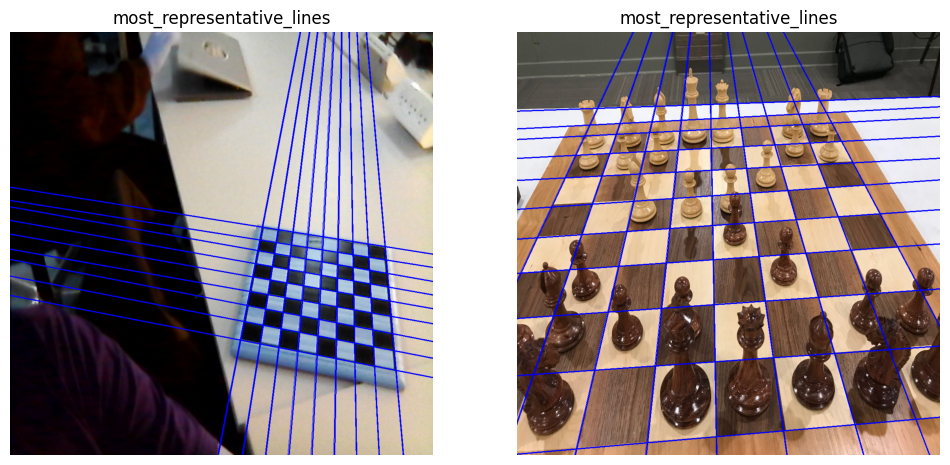

In [14]:
def most_representative_lines_indexes(corner_points_for_line):
    indexed = [(i, *item) for i, item in enumerate(corner_points_for_line)]
    # remove lines that have no harris points or only one harris point
    remove_empty = [item for item in indexed if len(item[2]) > 1]
    sorte = sorted(remove_empty, key=lambda x: len(x[2]), reverse=True)

    if len(sorte) == 0:
        print("no lines found")
        exit()

    # find lines that have the most harris points, without having any other line with more than 1 point in common
    # if there are multiple lines with the same amount of points, choose the one with the smallest distance to the harris points
    most_representative_lines = [sorte[0][0]]
    for i, distance,  harris_points in sorte:
        add = True
        for line in most_representative_lines:
            if np.intersect1d(harris_points, corner_points_for_line[line][1]).size > 1:
                add = False
                break

        if add:
            most_representative_lines.append(i)

    return most_representative_lines

other_data["most_representative_lines_indexes"] = [most_representative_lines_indexes(corner_points_for_line) for corner_points_for_line in other_data["corner_points_for_line"]]
other_data["most_representative_lines"] = [[lines[i] for i in indexes] for lines, indexes in zip(other_data["hough"], other_data["most_representative_lines_indexes"])]

imgs["most_representative_lines"] = [img.copy() for img in imgs["original"]]

for img, lines in zip(imgs["most_representative_lines"], other_data["most_representative_lines"]):
    draw_algebraic_lines(img, lines, color=(255, 0, 0))

show_imgs("most_representative_lines")

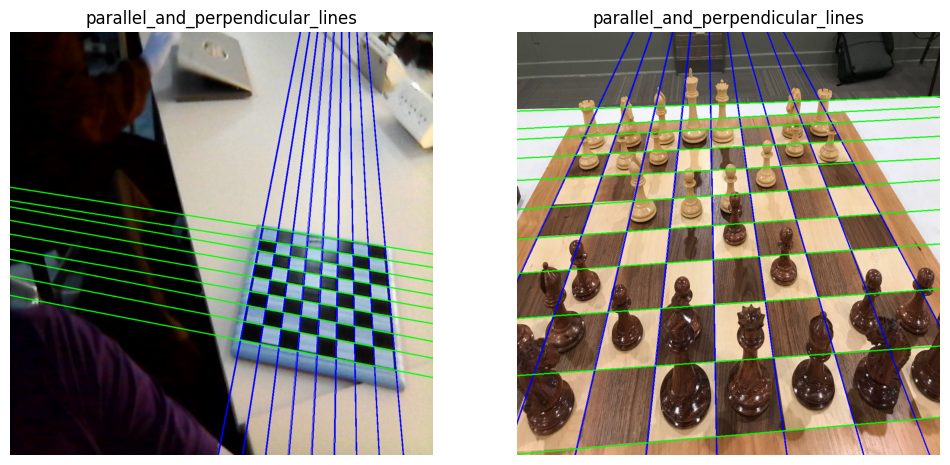

In [15]:
def remove_non_parallel_lines(lines, margin = 1):
    # remove lines that are not parallel to at least one other line
    parallel = []
    for i, line in enumerate(lines):
        rho, theta = line
        for other_line in lines:
            if np.array_equal(line, other_line):
                continue

            other_rho, other_theta = other_line
            if abs(theta - other_theta) < margin:
                parallel.append(i)
                break

    return [lines[i] for i in parallel]

def split_lines_to_parallel_and_perpendicular(lines):
    parallel = []
    perpendicular = []
    for line in lines:
        rho, theta = line
        if abs(theta - math.pi/2) < math.pi/4:
            perpendicular.append(line)
        else:
            parallel.append(line)
    return parallel, perpendicular

other_data["parallel_lines"] = [remove_non_parallel_lines(lines) for lines in other_data["most_representative_lines"]]
other_data["parallel_and_perpendicular_lines"] = [split_lines_to_parallel_and_perpendicular(lines) for lines in other_data["parallel_lines"]]

imgs["parallel_and_perpendicular_lines"] = [img.copy() for img in imgs["original"]]
for img, lines in zip(imgs["parallel_and_perpendicular_lines"], other_data["parallel_and_perpendicular_lines"]):
    draw_algebraic_lines(img, lines[0], color=(255, 0, 0))
    draw_algebraic_lines(img, lines[1], color=(0, 255, 0))

show_imgs("parallel_and_perpendicular_lines")